<center><h2>M1 MMA - Optimisation sous contraintes</h2><h3>Correction du DM1 : implémentation de l'algorithme Frank-Wolfe.</h3></center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Pour rappel, on implémente l'algorithme de FW qui produit une suite $(x_k)_{k\in\mathbb N}$ d'éléments de $C$ telle que pour $x_0\in C$ choisi par l'utilisateur, on a 
\begin{equation*}
	\forall k\in\mathbb N, \quad \begin{cases} s_k \in \mathrm{argmin}_{s\in C} \langle \nabla f(x_k), s\rangle,\\
							\lambda_k = \frac2{k+2},\\
							x_{k+1} = (1-\lambda_k)x_k + \lambda_k s_k.
						\end{cases}
\end{equation*}
Avec $f : x\in\mathbb{R}^n\mapsto \frac12\|Ax - y\|_2^2$ telle que $A \in \mathcal M_{m,n}(\mathbb{R})$, $y \in \mathbb{R}^m$ et
\begin{align*}
	C = \{x\in\mathbb{R}^n / \|x\|_2 \leq 1\} \cap (\mathbb{R}_+)^n.
\end{align*}

<b>Implémentation de l'algorithme Frank-Wolfe.</b>

Il prend notamment en argument la fonction "resoudre_linearisable" qui est utilsée dans le code comme une boîte noire. Cette fonction est censée renvoyer une solution du problème suivant
\begin{align}
    \min_{s\in C} \, \langle \nabla f(x_k), s\rangle, \tag{$\mathcal L$}
\end{align}
appelé dans la suite problème linéarisé. Cette fonction est à adapter en fonction des spécificités du problème d'optimisation (dépend de l'ensemble $C$ des contraintes). Nous en ferons une implémentation ultérieure dans la suite du document pour le problème qui nous concerne.

In [2]:
def frank_wolfe(x0, gradf, resoudre_linearisation, tol, max_iter = 10000):
    # Implémentation de l'algorithme de Frank-Wolfe
    
    # - x0 : position initiale, x0 \in C
    # - gradf : fonction codant le gradient de la fonction objectif.
    # - resoudre_linearisation : fonction implémentant une méthode de résolution du problème linéarisé.
    # Prend en argument le gradient de f en x
    # - tol : tolérance pour le critère d'arrêt
    # - max_iter : nombre maximium d'itérations autorisé
    
    k = 0
    x = x0
    x_list = [x] # va contenir la liste des itérées calculées par l'algorithme
    
    # On effectue un premier pas hors boucle de algo FW pour initialiser valeur intervenant dans critère d'arrêt
    gradfx = gradf(x)
    s = resoudre_linearisation(gradfx)
    pente = np.dot(gradfx, s - x) # <gradf(x), s - x> : "pente" de f dans la direction s - x
    pente_list = [] # va contenir la liste des pentes de f dans les directions s - x
    pente_list.append(pente)
    
    while pente <= -tol and k < max_iter: # pour un commentaire sur le critère d'arrêt, voir la correction du TP noté
        lbda = 2/(k + 2)
        x = (1 - lbda)*x + lbda*s # on met à jour l'itéré x comme défini dans l'algorithme FW
        gradfx = gradf(x) # on calcule le nouveau gradient en x
        s = resoudre_linearisation(gradfx) # on résoud le nouveau problème linéarisé min_{s\in C} <gradf(x), s>
        pente = np.dot(gradfx, s - x) # on calcule la nouvelle pente utilisée dans le critère d'arrêt
        x_list.append(x)
        pente_list.append(pente)
        k += 1
    return x, x_list, pente_list

<b>Définitions des paramètres du problème d'optimisation.</b>

In [3]:
m, n = 5, 10

A = np.random.randn(m, n)
y = np.random.randn(m)

In [4]:
def f(x):
    return .5*np.linalg.norm(np.dot(A, x) - y)**2
def gradf(x):
    return np.dot(A.transpose(), np.dot(A, x) - y)

<b>Implémentation de la fonction résolvant le problème linéarisé $(\mathcal L)$, dans le cas de l'ensemble $C$ précisé au début de ce document.</b>

Une solution à ce problème dit linéarisé, pour le $C$ particulier qui nous concerne ici, est donnée dans la correction du sujet d'examen 2021/2022. L'algorithme ci-dessous est une implémentation de "l'Algorithme 1" également donné dans le correction de ce sujet.

In [5]:
# Note : si v est un array alors la commande "v < 0" renvoie un arrêt dont les coeff sont des booléens,
# TRUE si v[k] < 0, FALSE si v[k] >= 0.
# Effectuer des opérations mathématiques sur un vecteur de booléen convertit ce vecteur en un vecteur composé de 1
# ou 0. 1 si TRUE, 0 si FALSE.

def resoudre_linearisation(gradfx):
    if sum(gradfx < 0) == 0: # on teste s'il n'y a aucun coefficient de nabla f(x) strictement négatif.
        # Car alors on sait que 0 est solution du problème linéairisé d'après l'étude faite dans l'examen.
        return np.zeros(len(gradfx))
    else:
        # sinon il y a au moins un coeff strictement négatif et une solution est donnée par la formule suivante
        d = (gradfx < 0)*gradfx
        return -1/np.linalg.norm(d)*d

<b>Utilisation de l'algorithme dans le cas particulier choisi.</b>

In [6]:
# on résoud le problème d'optim grâce à l'algo FW
x0 = np.zeros(n) # on initialise l'algorithme en 0_{R^n} qui est bien dans C
x, x_list, pente_list = frank_wolfe(x0, gradf, resoudre_linearisation, 1e-5)

print("Solution approchée trouvée : ", x)
print("Nombre d'itérations : ", len(x_list))

Solution approchée trouvée :  [1.64002355e-01 7.80747050e-01 4.07986632e-01 2.05150070e-08
 1.95032854e-01 0.00000000e+00 8.59350052e-03 3.98035466e-01
 6.39447348e-05 5.22160908e-08]
Nombre d'itérations :  7244


<b>Illustration de la convergence</b>

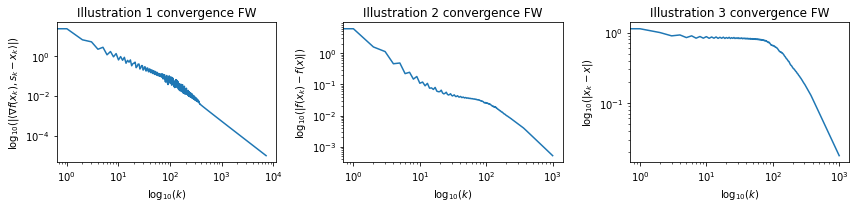

In [7]:
plt.figure(figsize = (12, 3))
plt.subplot(131)
plt.loglog(abs(np.array(pente_list)))
plt.xlabel(r"$\log_{10}(k)$")
plt.ylabel(r"$\log_{10}(|\langle \nabla f(x_k), s_k - x_k\rangle|)$")
plt.title("Illustration 1 convergence FW")

plt.subplot(132)
plt.loglog([abs(f(x_list[i]) - f(x)) for i in range(1000)])
plt.xlabel(r"$\log_{10}(k)$")
plt.ylabel(r"$\log_{10}(|f(x_k) - f(x)|)$")
plt.title("Illustration 2 convergence FW")

plt.subplot(133)
plt.loglog([np.linalg.norm(x_list[i] - x) for i in range(1000)])
plt.xlabel(r"$\log_{10}(k)$")
plt.ylabel(r"$\log_{10}(\|x_k - x\|)$")
plt.title("Illustration 3 convergence FW")

plt.tight_layout()
plt.show()

On a représenté trois quantités permettant d'observer la convergence de la suite produite par l'algorithme Frank-Wolfe. Les deuxième et troisième figures sont classiques. La première l'est moins. Voir le document pdf associé aux questions théoriques du TP évalué. Cette discussion a un lien avec le critère d'arrêt choisi dans la fonction FW.

Les axes de ces figures sont tous les deux en échelle logarithmique. Pour rappel, mettre uniquement l'axe des ordonnées en échelle $\log$ (grâce à la fonction plt.semilogy) permet d'illustrer les convergence linéaires i.e. celles dont l'erreur se comporte en $\alpha^k$ avec $0<\alpha<1$, puisqu'alors on doit observer (au moins asymptotiquement) une droite de pente $\log(\alpha) < 0$. Mettre les deux axes en échelle $\log$ permet d'illustrer les convergences sous-linéaires du type dont l'erreur est en $\frac1{k^\alpha}$ avec $\alpha > 0$, puisqu'alors le $\log$ de l'erreur est en $-\alpha \log(k)$ et le comportement de cette quantité dépend linéairement de $\log(k)$ (d'où le fait de passer également l'axe des abscisse en $\log$).

On remarque que pour chacun de ces graphes, on observe un comportement asymptotique linéaire dont les pentes semblent être $-1$ pour les graphes 1 et 3, donc $\alpha = 1$, mais $-2$ pour le deuxième. Ainsi la vitesse de convergence de la suite $(f(x_k))_k$ semble être en $\frac{1}{k^2}$ et celle de $(x_k)_k$ sont en $\frac1k$. Le comportement théorique attendue pour la vitesse de convergence de $(f(x_k))_k$ est dans le pire des cas en $\frac1k$ (voir la correction de l'examen 2021/2022).